In [42]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.visualization.modules import CanvasGrid
from mesa.datacollection import DataCollector

import ipywidgets as widgets

import asyncio

%matplotlib widget
import matplotlib.pyplot as plt

import random
import numpy as np
import pandas as pd

## Überschrift ##

In [43]:
class SchellingAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = random.choice([0,1])
        
    def step(self):
        #print(f'Hi, I am agent {self.unique_id}')
        #print(f'My state is {self.state}')
        self.state = random.choice([0,1])

In [44]:
class SchellingModel(Model):
    def __init__(self, N, width, height):
        self.grid = MultiGrid(width, height, True)
        self.agents = []
        self.num_agents = N
        self.schedule = RandomActivation(self)
        for i in range(0, N):
            a = SchellingAgent(i, self)
            self.schedule.add(a)
            
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            self.agents.append(a)
        self.datacollector = DataCollector(          
            agent_reporters={"State": "state"})
        
    def reset():
        for a in self.agents:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
    def step(self):
        self.schedule.step()

In [45]:
model = SchellingModel(20,50,50)

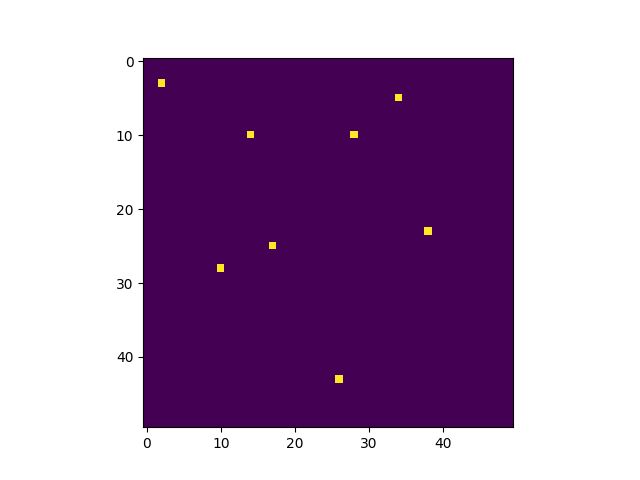

In [60]:
def grid_values(model):
    """Get grid cell states"""

    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=pd.DataFrame(agent_counts)
    for cell in model.grid.coord_iter():
        agents, x, y = cell
        c=None
        for a in agents:
            c = a.state
            df.iloc[x,y] = c
    return df

data = grid_values(model).values

loop = asyncio.get_event_loop()
sim = None

fig = plt.figure()
im = plt.imshow(data, interpolation='None', animated=True)

async def run_sim(num_ticks):
    for i in range (0,num_ticks):
        model.step()
        im.set_data(grid_values(model).values)
        fig.canvas.draw()
        await asyncio.sleep(0.1)
    
btStart = widgets.Button(
    description='Start simulation',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me'
)

btStop = widgets.Button(
    description='Stop simulation',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me'
)

btReset = widgets.Button(
    description='Reset simulation',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me'
)

output = widgets.Output()

def on_btStart_clicked(b):
    global sim
    sim = loop.create_task(run_sim(100))
    
def on_btStop_clicked(b):
    global sim
    sim.cancel()
    
def on_btReset_clicked(b):
    global model
    model = SchellingModel(20,50,50)
    im.set_data(grid_values(model).values)
    fig.canvas.draw()

btStart.on_click(on_btStart_clicked)
btStop.on_click(on_btStop_clicked)
btReset.on_click(on_btReset_clicked)

plt.show()

hbox = widgets.HBox([btStart, btStop, btReset, output])
display(box)
